# Geodetic motion in Schwarzschild geometry

### The metric and the geodesic equation

The metric of the Schwarzschild space around a not charged, not spinnig black hole is $$ ds^2 = -(1-\frac{2GM}{c^2 r})c^2 dt^2 +(1-\frac{2GM}{c^2 r})^{-1} dr^2 + r^2 d\theta^2 + r^2 \sin(\theta)^2 d\phi^2 $$ 
The metric is described by $ g_{\mu \nu} = diag(-(1-\frac{2GM}{c^2 r}), (1-\frac{2GM}{c^2 r})^{-1}, r^2, r^2\sin(\theta)^2) $ 
 
The evolution of a massive body in geodesic motion is described by
$$ \begin{equation}
    \begin{cases}
      \frac{dx^\mu}{d \tau}= u^\mu\\
      \frac{du^\alpha}{d \tau} + \Gamma^\alpha_{\beta \gamma}u^\beta u^\gamma = 0
    \end{cases}\
\end{equation} $$
The equation can be integrated in the proper time to obtain the coordinate time and the position of the body $ x^\mu = (t, r, \theta, \phi) $ 
 
  
The non-zero Christoffel symbols with $ R_S = \frac{GM}{c^2} $, are

$$ \begin{matrix}
  \Gamma^t_{rt}= \frac{R_S}{r(r-2R_S)}   &   \Gamma^r_{tt}= \frac{R_S(r-2R_S)}{r^3} &   \Gamma^r_{rr}= -\frac{R_S}{r(r-2R_S)} \\ 
   &   \Gamma^r_{\phi\phi}= -(r-2R_S)\sin^2\theta  &  
 \Gamma^\phi_{r\phi}= \frac{1}{r} &     &   

\end{matrix} $$

In [1]:
%matplotlib widget
#Libraries for solving the ODE and handling the data
from scipy.integrate import solve_ivp
import pandas as pd
import numpy as np

#Libraries for the rendering
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import display, clear_output, HTML

np.set_printoptions(precision=4)


### Definitions of the metric and the Christoffel symbols

In [2]:
# The metric depends on the point where it is calculated

def metric(Rs):
  return lambda x: np.diag([-(1-2*Rs/x[1]),(1-2*Rs/x[1])**-1, x[1]**2, (x[1]*np.sin(x[2]))**2])

# Christoffel symbols

def Chr(x, Rs):
  r, theta = x[1], x[2]
  ch = np.zeros((4,4,4))
  ch[1][0][0] = Rs*(r-2*Rs)/r**3      # r-tt
  ch[0][1][0] = Rs/(r*(r-2*Rs))    # t-rt
  ch[0][0][1] = Rs/(r*(r-2*Rs))    # t-tr
  
  ch[1][1][1] = -Rs/(r*(r-2*Rs))    # r-rr
  
  ch[1][2][2] = -(r-2*Rs)     # r-theta theta
  ch[2][1][2] = 1/r    # theta - r theta
  ch[2][2][1] = 1/r     # theta - theta r
  
  ch[1][3][3] = -(r-2*Rs)*np.sin(theta)**2   # r- phi phi
  ch[3][1][3] = 1/r    # phi- r phi
  ch[3][3][1] = 1/r    # phi- phi r
  
  ch[2][3][3] = -np.sin(theta)*np.cos(theta)   # theta - phi phi
  ch[3][2][3] = np.cos(theta)/np.sin(theta)   # phi - theta phi
  ch[3][3][2] = np.cos(theta)/np.sin(theta)   # phi - phi theta
  
  return ch

def Christoffel(Rs):
  return lambda x: Chr(x,Rs)

def dot(a,b,g): #Doct product with the metric
  return np.dot(b,np.dot(g, a))

def spher2cart(x):  #Spherical to cartesian coordinates
  r, theta, phi = x[0], x[1], x[2]
  return (r*np.sin(theta)*np.cos(phi), r*np.sin(theta)*np.sin(phi), r*np.cos(theta))
  

In [3]:
G, M, c = 1.0, 1.0, 1.0
Rs = G*M/c**2

print(f'The Schwarzschild radius is {Rs}')
g = metric(Rs)
christoffel = Christoffel(Rs)


The Schwarzschild radius is 1.0


## Initial conditions of the system

In [4]:
#Initial position and speed

x = (1.2e1, 0.5*np.pi, 0)  # (r, theta, phi)
v = (0,0.0,0.260821)         # (v_r, v_theta, v_phi) in c units

x_cart = spher2cart(x)
print(f'The initial position is (r: {x[0]}, theta: {x[1]}, phi: {x[2]}) or (x: {x_cart[0]}, y: {x_cart[1]}, z: {x_cart[2]})')

dx = (v[0], v[1]/x[0], v[2]/(x[0]*np.sin(x[1]))) #dx/dt: dr = v_r, dtheta = v_theta/r, dphi = v_phi/(r*sin(theta))
print(f'The initial velocity is (v_r: {v[0]}, v_theta: {v[1]}, v_phi: {v[2]}) or (dr/dt: {dx[0]}, dtheta/dt: {dx[1]}, dphi/dt: {dx[2]})')
print(f'The total velocity is {np.linalg.norm(v)} c')

#Initial 4-vectors
x = np.array([0, x[0], x[1], x[2]])

# u is found by using u*u = -1 and u0 = dt/dtau
u = np.array([1, dx[0], dx[1], dx[2]])
u0 = (-1/dot(u,u,g(x)))**0.5
u = u0*u

print(f'The 4-position is {x}')
print(f'The 4-velocity is {u}')


The initial position is (r: 12.0, theta: 1.5707963267948966, phi: 0) or (x: 12.0, y: 0.0, z: 7.347880794884119e-16)
The initial velocity is (v_r: 0, v_theta: 0.0, v_phi: 0.260821) or (dr/dt: 0, dtheta/dt: 0.0, dphi/dt: 0.021735083333333335)
The total velocity is 0.260821 c
The 4-position is [ 0.     12.      1.5708  0.    ]
The 4-velocity is [1.1431 0.     0.     0.0248]


In [5]:
def ODE(tau, y):
  x, u = y[0:4], y[4:]
  return np.concatenate([u,-np.dot(np.dot(u, christoffel(x)), u)])

t0, tf = 0, 2e3

y0 = np.concatenate([x,u])
Y = solve_ivp(ODE, t_span=(t0, tf), y0=y0, t_eval = np.linspace(t0,tf,10000), rtol=1e-12)

planet = pd.DataFrame({'T':Y.t, 't':Y.y[0], 'r':Y.y[1], 'theta':Y.y[2], 'phi':Y.y[3], 'ut':Y.y[4], 'ur':Y.y[5], 'utheta':Y.y[6], 'uphi':Y.y[7]})


planet['x'] = planet['r']*np.sin(planet['theta'])*np.cos(planet['phi'])
planet['y'] = planet['r']*np.sin(planet['theta'])*np.sin(planet['phi'])
planet['z'] = planet['r']*np.cos(planet['theta'])

planet.head()


,T,t,r,theta,phi,ut,ur,utheta,uphi,x,y,z
0,0.00000,0.000000,12.000000,1.570796,0.000000,1.143095,0.000000,0.000000e+00,0.024845,12.000000,0.000000,7.347881e-16
1,0.20002,0.228642,11.999972,1.570796,0.004970,1.143096,-0.000278,7.560397e-21,0.024845,11.999824,0.059634,7.347864e-16
2,0.40004,0.457284,11.999889,1.570796,0.009939,1.143098,-0.000556,1.512107e-20,0.024846,11.999296,0.119267,7.347813e-16
3,0.60006,0.685927,11.999750,1.570796,0.014909,1.143100,-0.000833,2.268231e-20,0.024846,11.998416,0.178896,7.347728e-16
4,0.80008,0.914570,11.999555,1.570796,0.019879,1.143104,-0.001111,3.024439e-20,0.024847,11.997185,0.238520,7.347609e-16


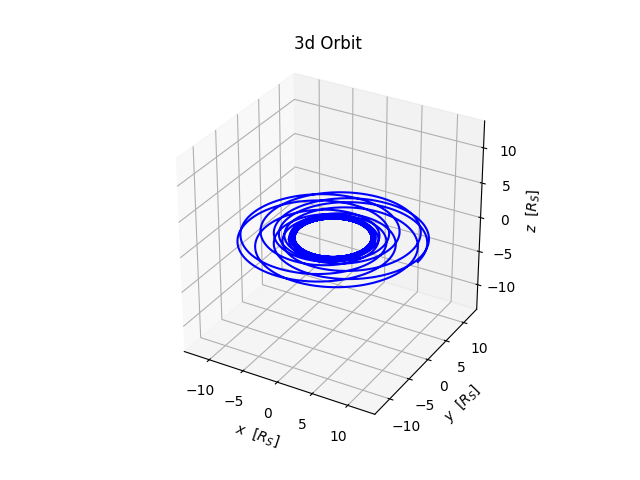

In [6]:
fig = plt.figure('orbit')
ax = fig.add_subplot(projection='3d')
ax.set_title('3d Orbit')
ax.set_aspect('equal')

max_r = 1.1*max(planet['r'])
ax.set_xlabel(r'$x$  $ [R_S]$')
ax.set_ylabel(r'$y$  $ [R_S]$')
ax.set_zlabel(r'$z$  $ [R_S]$')
ax.set_xlim([-max_r, max_r])
ax.set_ylim([-max_r, max_r])
ax.set_zlim([-max_r, max_r])


ax.plot(planet['x'], planet['y'], planet['z'], 'b-')
plt.show()


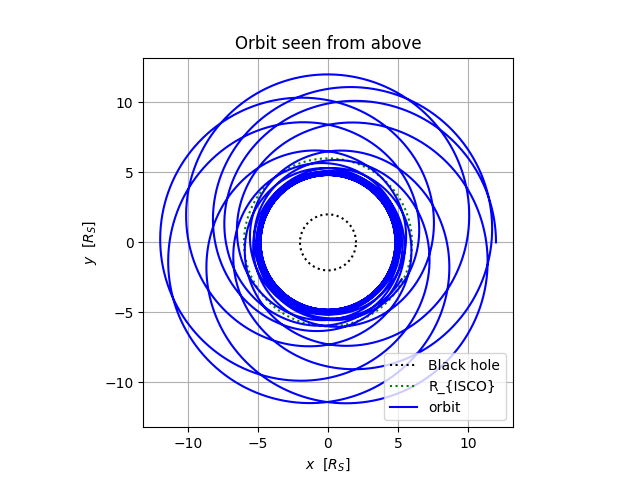

In [7]:
fig, ax = plt.subplots()
ax.set_title('Orbit seen from above')
ax.set_aspect('equal')

max_r = 1.1*max(planet['r'])
ax.set_xlabel(r'$x$  $ [R_S]$')
ax.set_ylabel(r'$y$  $ [R_S]$')
ax.set_xlim([-max_r, max_r])
ax.set_ylim([-max_r, max_r])
ax.grid()
phi = np.linspace(0, 2*np.pi, 100)
BH = ax.plot(2*Rs*np.cos(phi), 2*Rs*np.sin(phi), 'k:', label = 'Black hole')
ISCO = ax.plot(6*Rs*np.cos(phi), 6*Rs*np.sin(phi), 'g:', label=r'R_{ISCO}')
ax.plot(planet['x'], planet['y'], 'b-', label = 'orbit')
ax.legend()


In [8]:
#Creation of the plot and the artists inside

def create_plot(data_frames, Rs):
  fig, ax = plt.subplots()
  max = []
  for df in data_frames:
    max.append(1.1*np.abs(df['r']).max()) #Find the maximum distance from the origin 
    
  fig.suptitle('Orbit around a black hole')      
  max_r = np.array(max).max() 
  
  ax.set_xlabel(r'$x$  $ [R_S]$')
  ax.set_ylabel(r'$y$  $ [R_S]$')
  ax.set_xlim([-max_r, max_r])
  ax.set_ylim([-max_r, max_r])
  ax.set_aspect('equal')
  ax.grid()
  phi = np.linspace(0, 2*np.pi, 100)
  BH = ax.plot(2*Rs*np.cos(phi), 2*Rs*np.sin(phi), 'k:', label = 'Black hole')
  ISCO = ax.plot(6*Rs*np.cos(phi), 6*Rs*np.sin(phi), 'g:', label=r'$R_{ISCO}$')
  time = ax.text(0.05,0.9,'', transform = ax.transAxes)
  
  #NB: both traces and markers are memorized as an array of arrays containing the single element
  traces = [ax.plot(0,0, linestyle = '-', alpha=0.5) for df in data_frames]
  markers = [ax.plot(0,0, c = trace[0].get_color(),linestyle='', marker = '*') for trace in traces]
  plt.close('all')
  ax.legend()
  return fig, [traces, markers, time, BH, ISCO]



In [9]:

#Functions to plot, update the plot and animate it updating the artists inside

#Plots the figure by updating the objects inside
def plot_figure(data_frames, t_span=None, Rs = 1.0):
  data_frames = (lambda x: x if type(x) is tuple else (x,))(data_frames)  #If the input is a single element make it a tuple, else, execute normally
  fig, artists = create_plot(data_frames, Rs)
  traces, markers, time = artists[0], artists[1], artists[2]    
  
  # reduce the dataframes to the time limits 
  if t_span != None:  
    time.set_text(f't = {t_span[1]:.2f}')
    data_restricted = [df[(df['t'] >= t_span[0]) & (df['t'] <= t_span[1])] for df in data_frames]
  else:
    data_restricted = data_frames

  #for all couples plot, df set the data of the plots
  for trace, df in zip(traces, data_restricted): trace[0].set_data(df['x'], df['y']) 
  for marker, df in zip(markers, data_restricted): marker[0].set_data([df.iloc[-1][ 'x']], [df.iloc[-1][ 'y']])   
  display(fig)

#Realtime animation 
def animate_RT(data_frames, time_step = 0.05, tail=-1, t_span=None, Rs=1.0):  
  data_frames = (lambda x: x if type(x) is tuple else (x,))(data_frames)  
  fig, artists = create_plot(data_frames, Rs)  
  if t_span == None:
    t_stop, t_start = data_frames[0].iloc[-1]['t'], data_frames[0].iloc[0]['t'] #Beginning and end of the animation
  else:
    t_start, t_stop = t_span[0], t_span[1]
  t = t_start
  
  while t<=t_stop:
    update(t, tail, data_frames, artists)
    display(fig)
    clear_output(wait=True) 
    t = t + time_step

#Update the frame of animation
def update(t, tail, data_frames, artists, t_step=None):
  #In RT animation t is the final time, in funcAnimation is the frame of the image 
  # so I scale it back to the time
  if t_step != None:
    t = t*t_step
  traces, markers, time = artists[0], artists[1], artists[2]    
  time.set_text(f't = {t:.2f}')
  if tail>0:
    data_restricted = [df[(df['t'] >= t-tail) & (df['t'] <= t)] for df in data_frames] 
  else : 
    data_restricted = [df[(df['t'] <= t)] for df in data_frames] 
  for trace, df in zip(traces, data_restricted): trace[0].set_data(df['x'], df['y']) 
  for marker, df in zip(markers, data_restricted): marker[0].set_data([ df.iloc[-1][ 'x']], [ df.iloc[-1][ 'y']])   

#HTML animation usin FuncAnimation
def animate_HTML(data_frames, duration=5.0, tail = -1, fps=15, t_span=None, Rs=1.0):
  data_frames = (lambda x: x if type(x) is tuple else (x,))(data_frames) 
  
  if t_span == None:
    t_stop, t_start = data_frames[0].iloc[-1]['t'], data_frames[0].iloc[0]['t'] #Beginning and end of the animation
  else:
    t_start, t_stop = t_span[0], t_span[1]
    
  fig, artists = create_plot(data_frames, Rs)
  n_frames = round(duration*fps)  #Total number of frames
  t_step = (t_stop-t_start)/n_frames  # Time step for frame
  ani = animation.FuncAnimation(fig, update, n_frames, fargs = (tail, data_frames, artists, t_step), interval = 1000.0/fps, blit=False)
  return ani


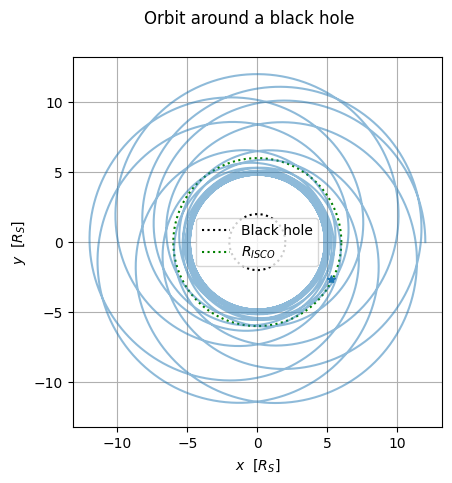

In [10]:
plot_figure(planet, Rs = Rs)


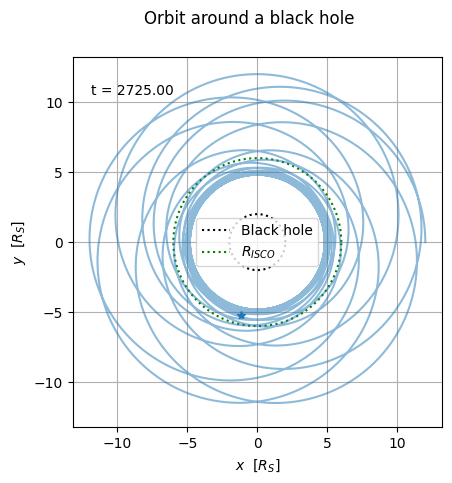

In [12]:
animate_RT(planet, Rs = Rs, time_step = 25)


In [ ]:
#ani = animate_HTML(planet, Rs = Rs, duration = 10)
#HTML(ani.to_jshtml())


In [ ]:
#ani.save('Orbit.gif')
